In [1]:
import numpy as np
from scipy.special import hankel2
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, RickerSource, Receiver
from devito import clear_cache, set_log_level
from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1

# Verification

We compute the error between the numerical and reference solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the error for these parameters.

In [3]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)

# Domain sizes and gird spacing
shapes = ((201, 2.0), (161, 2.5), (101, 4.0))
dx = [2.0, 2.5, 4.0]
nshapes = len(shapes)

# Number of time steps
nt = 1501
# Time axis
time = np.linspace(0., 150., nt)
# Source peak frequency
f0 = .07

In [4]:
# Fine grid model
c0 = 1.5
model = ModelBench(vp=c0, origin=(0., 0.), spacing=(1.0, 1.0), shape=(401, 401), nbpml=40, dtype=np.float64)

In [5]:
# Source and receiver
src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.data[:] = src.data[:] / c0**2
# Define receiver geometry (spread across x, just below surface)
rec = Receiver(name='rec', grid=model.grid, ntime=nt, npoint=1)
rec.coordinates.data[:, 0] = 260.
rec.coordinates.data[:, 1] = 260.

# Reference solution for numerical convergence

In [6]:
solver = AcousticWaveSolver(model, source=src, receiver=rec, time_order=2, space_order=20)

ref_rec, ref_u, _ = solver.forward()

GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-ri52snsj/8a83a306e5dfec2c851f118cdcd0f5d1fb19b074.c [0.67 s]
Section section_1<1499,1> with OI=0.56 computed in 0.001 s [0.06 GFlops/s]
Section section_2<1499,1> with OI=0.77 computed in 0.071 s [0.00 GFlops/s]
Section main<1499,461,461> with OI=2.75 computed in 1.655 s [13.86 GFlops/s, 0.19 GPts/s]


# Analytical solution for comparison with the reference numerical solution

The analytical solution of the 2D acoustic wave-equation with a source pulse is defined as:

$$
u_s(r, t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \{ -i \pi H_0^{(2)}\left(k r \right) q(\omega) e^{i\omega t} d\omega\}
$$

$$
r = \sqrt{(x - x_{src})^2+(y - y_{src})^2}
$$

where $H_0^{(2)}$ is the Hankel function of the second kind, $F(\omega)$ is the Fourier spectrum of the source time function at angular frequencies $\omega$ and $k = \frac{\omega}{v}$ is the wavenumber.

We look at the analytical and numerical solution at a single grid point. We ensure that this grid point is on-the-grid for all discretizations analyised in the further verification.

In [7]:
# Source and receiver coordinates
sx, sz = src.coordinates.data[0, :]
rx, rz = rec.coordinates.data[0, :]


# Fourier constants
nf = int(nt/2 + 1)
fnyq = 1. / (2 * model.critical_dt)
df = 1.0 / time[-1]
faxis = df * np.arange(nf)

# Define an Ricker wavelet shifted to zero lag for the Fourier transform
def ricker(f, T, dt, t0):
    t = np.linspace(-t0, T-t0, int(T/dt))
    tt = (np.pi**2) * (f**2) * (t**2)
    y = (1.0 - 2.0 * tt) * np.exp(- tt)
    return y

rick=ricker(f0, time[-1], model.critical_dt, 1.0/f0)

# Take the FOurier transform ofthe source time-function
R = np.fft.fft(rick/(c0**2))
R = R[0:nf]
nf = len(R)

# Compute the Hankel function and multiply by the source spectrum
U_a = np.zeros((nf), dtype=complex)
for a in range(1, nf):
    k = 2 * np.pi * faxis[a] / c0
    tmp = k * np.sqrt(((rx - sx))**2 + ((rz - sz))**2)
    U_a[a] = -1j * np.pi * hankel2(0,tmp) * R[a]
            

# Do inverse fft on 0:dt:T (third dimension on U) and you have analytical solution
U_t = 1/(2 * np.pi) * np.real(np.fft.ifft(U_a[:], nt))

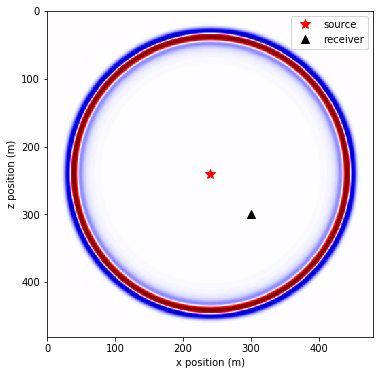

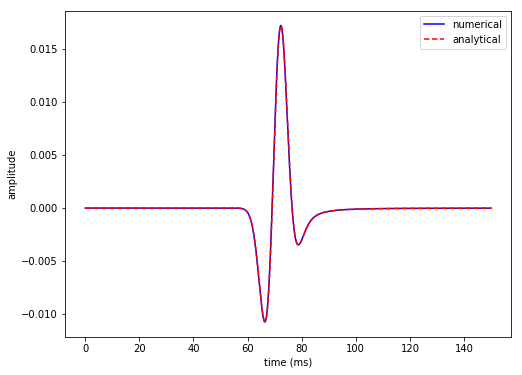

In [8]:
# Plot wavefield and source/rec position
plt.figure()
plt.imshow(ref_u.data[1,:,:], vmin=-.01, vmax=.01, cmap="seismic")
plt.plot(sx+40, sz+40, 'r*', markersize=11, label='source') # plot position of the source in model, add nbpml for correct position
plt.plot(rx+40, rz+40, 'k^', markersize=8, label='receiver')  # plot position of the receiver in model, add nbpml for correct position
plt.legend()
plt.xlabel('x position (m)')
plt.ylabel('z position (m)')
plt.savefig('wavefieldperf.pdf')

# Plot trace
plt.figure()
plt.plot(time, ref_rec.data[:, 0], '-b', label='numerical')
plt.plot(time, U_t[:], '--r', label='analytical')
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()
plt.savefig('ref.pdf')
plt.show()

In [9]:
np.linalg.norm(U_t[:] - ref_rec.data[:, 0], np.inf)

0.00036232711595681356

We have a correct refernce solution we can use for space discretization analysis

In [10]:
errorl2 = np.zeros((norder, nshapes))
timing = np.zeros((norder, nshapes))

set_log_level("ERROR")
ind_o = -1
for spc in orders:
    ind_o +=1
    ind_spc = -1
    for nn, h in shapes:
        ind_spc += 1
        clear_cache()
        model = ModelBench(vp=c0, origin=(0., 0.), spacing=(h, h), shape=(nn, nn),
                           nbpml=40, dtype=np.float64)
        src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)
        src.coordinates.data[0, :] = 200.
        src.data[:] = src.data[:] / (c0*h)**2

        # Define receiver geometry
        rec = Receiver(name='rec', grid=model.grid, ntime=nt, npoint=1)
        rec.coordinates.data[:, 0] = 260.
        rec.coordinates.data[:, 1] = 260.
        solver = AcousticWaveSolver(model, source=src, receiver=rec, time_order=2, space_order=spc)

        loc_rec, loc_u, summary = solver.forward()
        # Compare to reference solution
        errorl2[ind_o, ind_spc] = np.linalg.norm(loc_rec.data[:] - ref_rec.data[:], np.inf)
        timing[ind_o, ind_spc] = summary.timings['main']
        print("starting space order %s with (%s, %s) grid points the error is %s for %s seconds runtime" %
              (spc, nn, nn, errorl2[ind_o, ind_spc], timing[ind_o, ind_spc]))
        
        
        

starting space order 2 with (201, 201) grid points the error is 0.00598426580317 for 0.49342 seconds runtime
starting space order 2 with (161, 161) grid points the error is 0.00928847633862 for 0.345521 seconds runtime
starting space order 2 with (101, 101) grid points the error is 0.0166402800157 for 0.249449 seconds runtime
starting space order 4 with (201, 201) grid points the error is 0.000359318592844 for 0.498169 seconds runtime
starting space order 4 with (161, 161) grid points the error is 0.000906419933565 for 0.328145 seconds runtime
starting space order 4 with (101, 101) grid points the error is 0.00533975876155 for 0.213241 seconds runtime
starting space order 6 with (201, 201) grid points the error is 3.61125310506e-05 for 0.463921 seconds runtime
starting space order 6 with (161, 161) grid points the error is 0.000136598330446 for 0.307537 seconds runtime
starting space order 6 with (101, 101) grid points the error is 0.00194708892718 for 0.194697 seconds runtime
starting

In [11]:
timing

array([[ 0.49342 ,  0.345521,  0.249449],
       [ 0.498169,  0.328145,  0.213241],
       [ 0.463921,  0.307537,  0.194697],
       [ 0.393215,  0.309736,  0.198995],
       [ 0.399718,  0.370445,  0.216979]])

OpesciBench: Plotting ./TimeAccuracy.pdf 


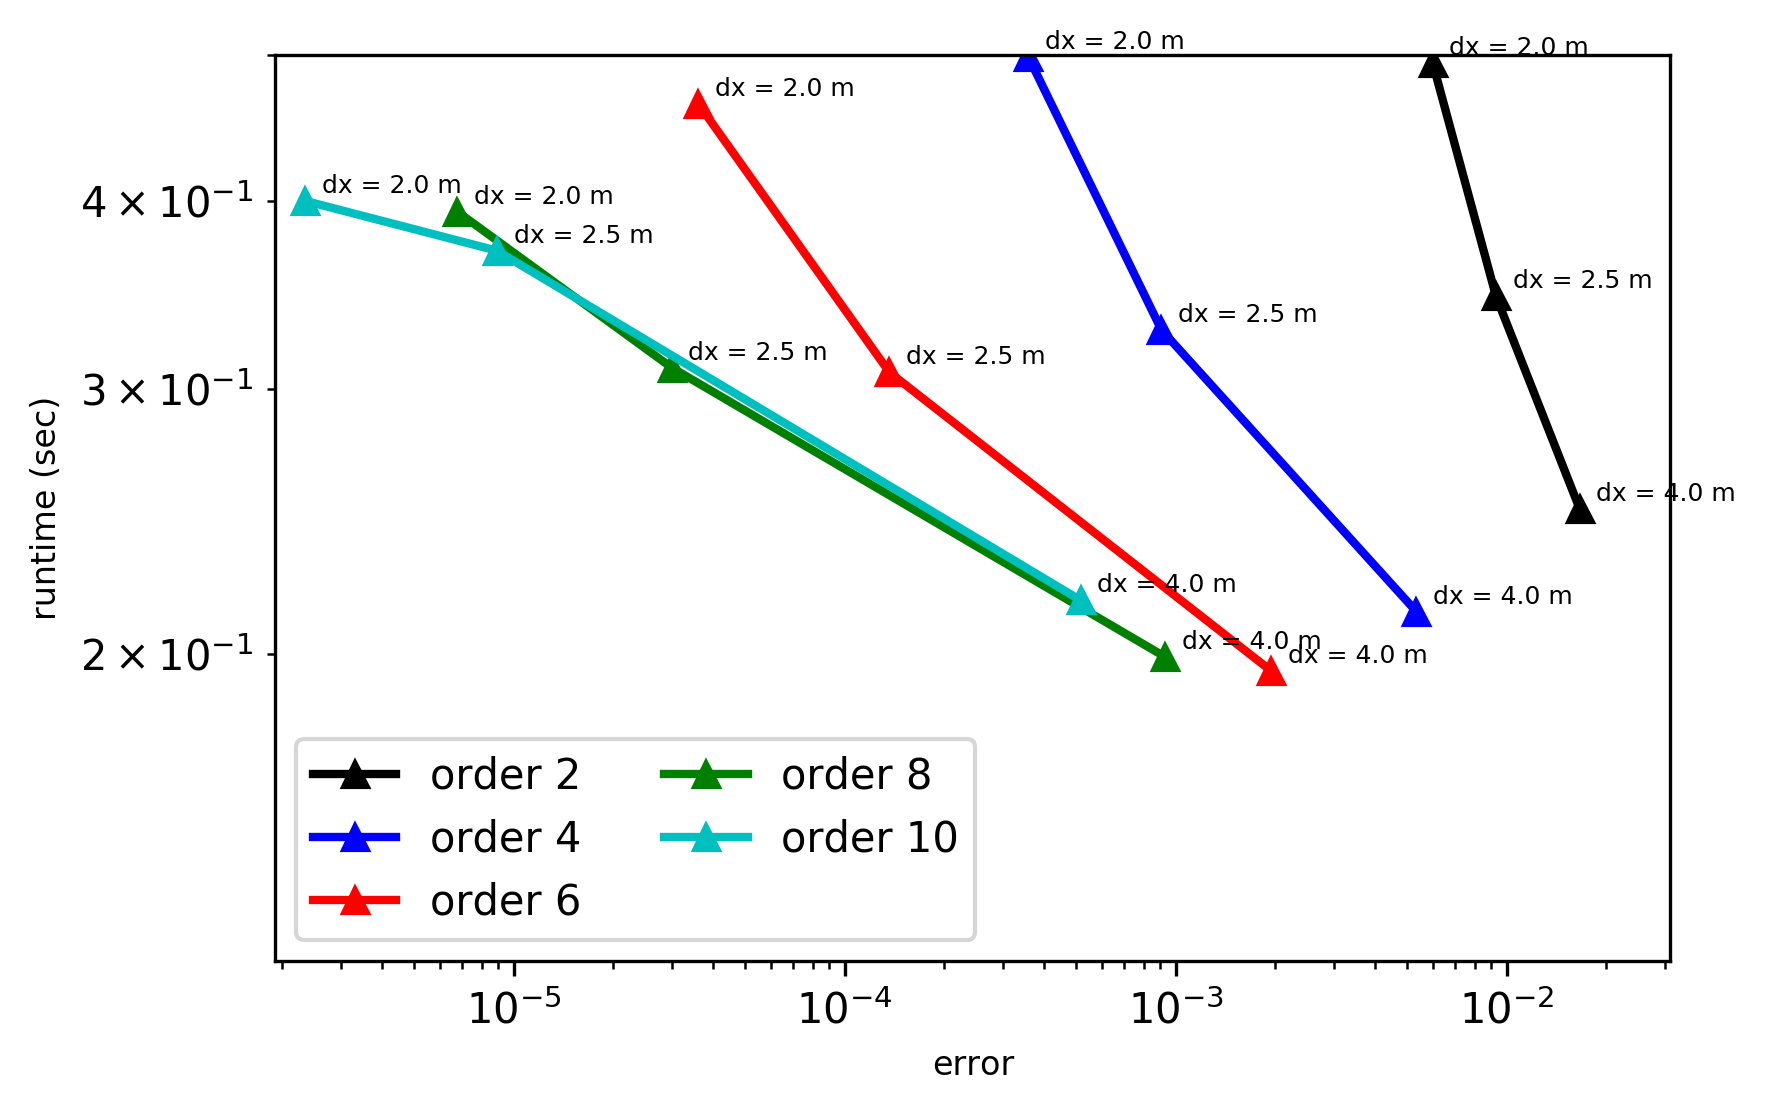

In [12]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
with LinePlotter(figname='TimeAccuracy.pdf', plotdir='./',  xlabel='error', ylabel='runtime (sec)') as plot:
    for i in range(0, 5):
        plot.add_line(list(errorl2[i, :]), list(timing[i, :]), label=('order %s' % orders[i]), style=stylel[i],
                      annotations=[('dx = %s m' % (sc)) for sc in dx])
    
plt.show()

OpesciBench: Plotting ./Convergence.pdf 


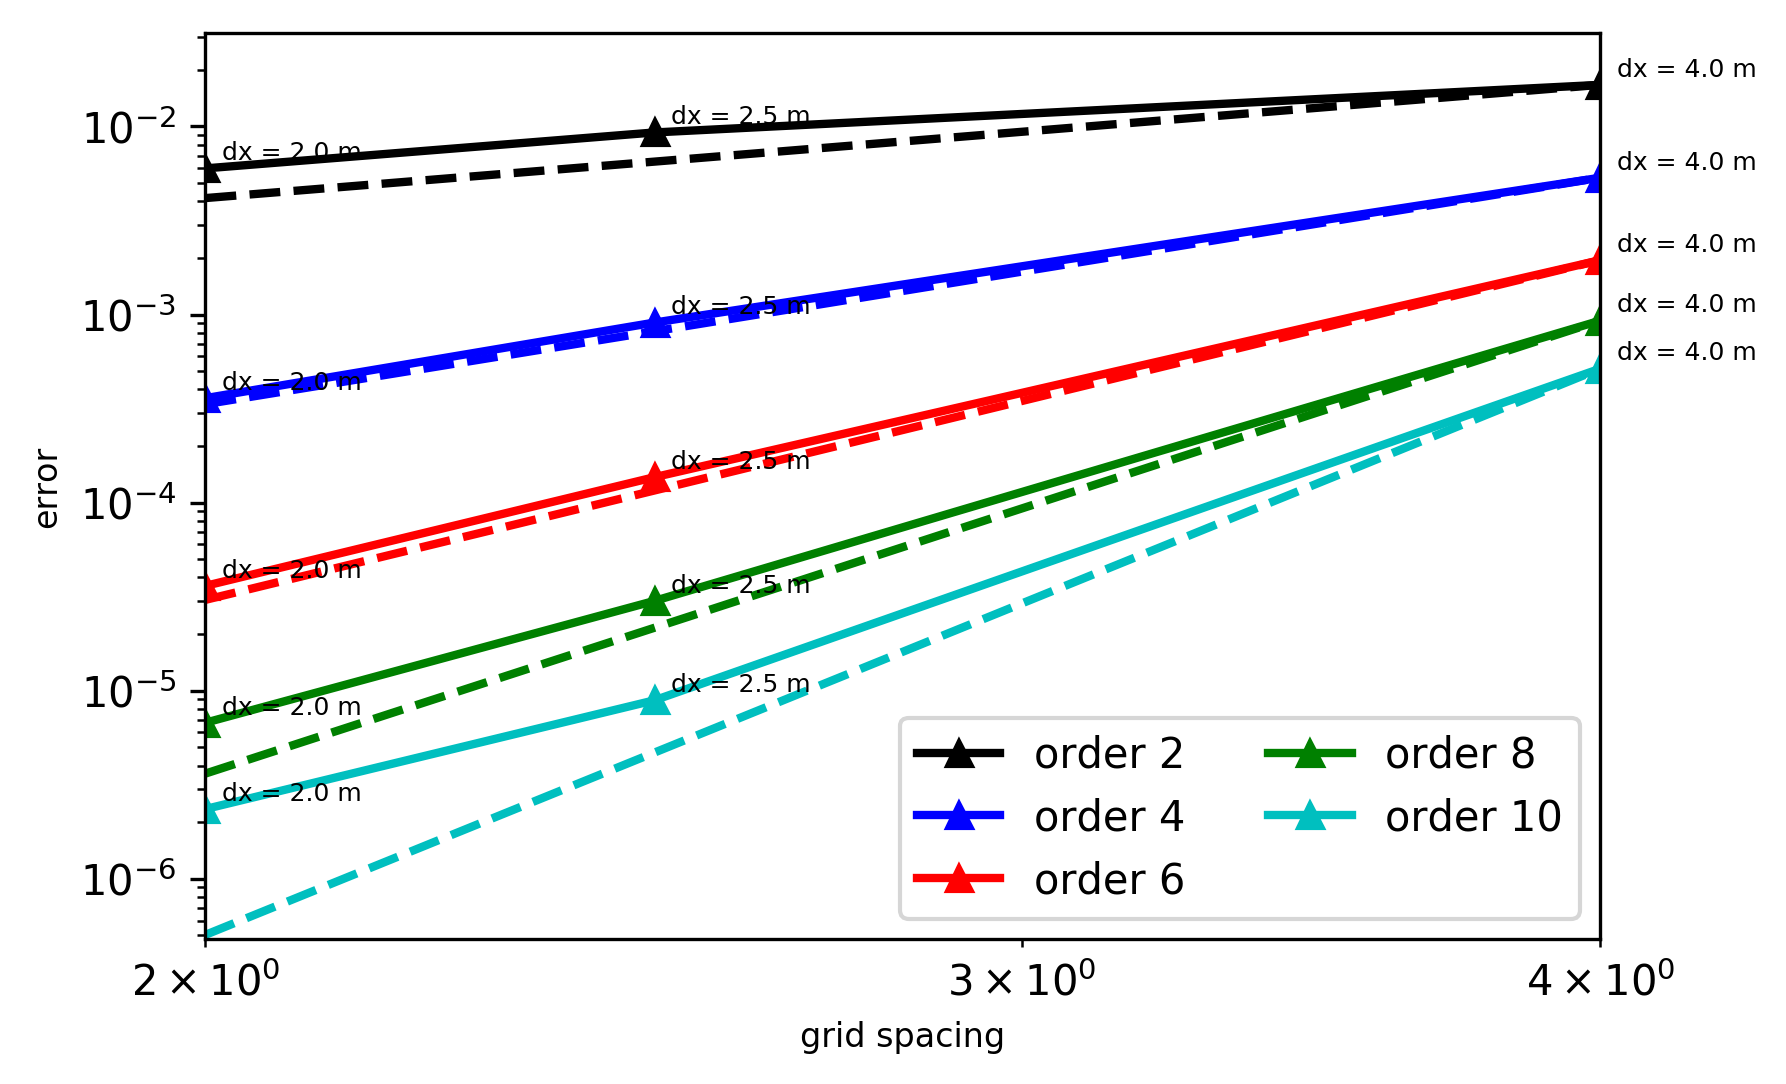

In [13]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

with LinePlotter(figname='Convergence.pdf', plotdir='./',  xlabel='grid spacing', ylabel = 'error') as plot:
    for i in range(0, len(orders)):
        theory = [k**(orders[i]) for k in dx]
        theory = [errorl2[i, 2]*th/theory[2] for th in theory]
        plot.add_line([sc for sc in dx], list(errorl2[i, :]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for sc in dx], style=stylel[i])
        plot.add_line([sc for sc in dx], list(theory), style=style2[i])

plt.show()